#Cell 1: Importing packages




In [2]:
import os
import zipfile
import shutil
import numpy as np
import random
from google.colab import drive
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix

#Cell 2: Data Loading

Unzipping Dataset and uploading it in my Google Colab Workspace.


In [3]:
drive.mount('/content/drive')
extract_path = '/content/'

with zipfile.ZipFile('/content/drive/MyDrive/MaskedFaceProject.zip', 'r') as zip_ref: zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path + 'MaskedFaceProject'))

base_dir = '/content/MaskedFaceProject'

# Verifying  folders exists before proceeding with later steps
assert os.path.exists(os.path.join(base_dir, 'CMFD')), "CMFD folder couldn't be found!"
assert os.path.exists(os.path.join(base_dir, 'IMFD')), "IMFD folder couldn't be found!"

Mounted at /content/drive
Extracted folders: ['CMFD', 'IMFD']


# Cell 3: Dataset Organization





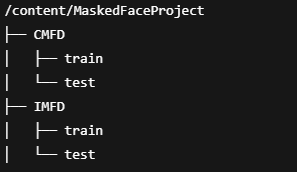

In [4]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

#Making sure to have clean existing directories to prevent contamination
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Class directories
classes = ['correct', 'incorrect']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

def organize_dataset(source_path, class_name, test_size=0.2):
    img_files = sorted([f for f in os.listdir(source_path) if f.lower().endswith('.jpg')]) #sorts the images alphabetically for consiistency

    # Stratified train-test split
    train_files, test_files = train_test_split(img_files,test_size=test_size, random_state=42, stratify=[0]*len(img_files)) #"satisfy" maintains class distribution


    print(f"\nOrganizing {class_name}:")

    # We Copy training files and test files
    for f in train_files:
        shutil.copy(os.path.join(source_path, f),os.path.join(train_dir, class_name, f))

    for f in test_files:
        shutil.copy(os.path.join(source_path, f), os.path.join(test_dir, class_name, f))

    print(f"-> Training: {len(train_files)} images")
    print(f"-> Test: {len(test_files)} images")

# Making sure that the Dataset is Organized successfully
try:
    organize_dataset(os.path.join(base_dir, 'CMFD'), 'correct')
    organize_dataset(os.path.join(base_dir, 'IMFD'), 'incorrect')
except Exception as e:
    print(f"\nError during dataset organization: {str(e)}")
    raise


Organizing correct:
-> Training: 12000 images
-> Test: 3000 images

Organizing incorrect:
-> Training: 12133 images
-> Test: 3034 images


# Cell 4: Data Visualization
Showed some samples to see what wearing correct and incorrect masks looks like

If nose, mouth or chin is shown, it is identified as incorrect, but if they all are covered, it is identified as correct

Training Samples:


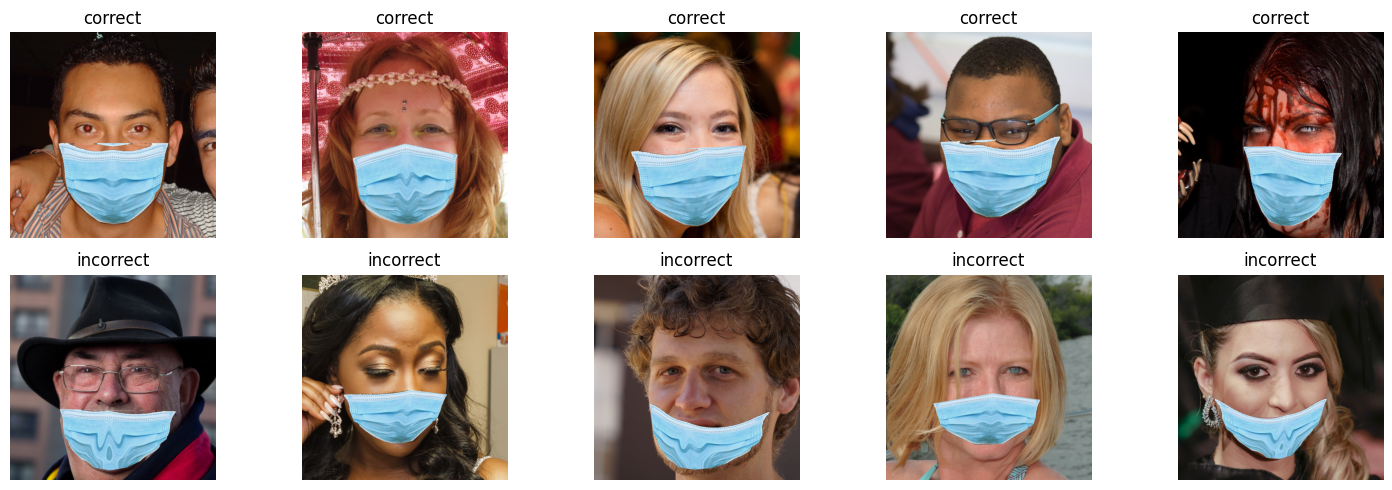


Test Samples:


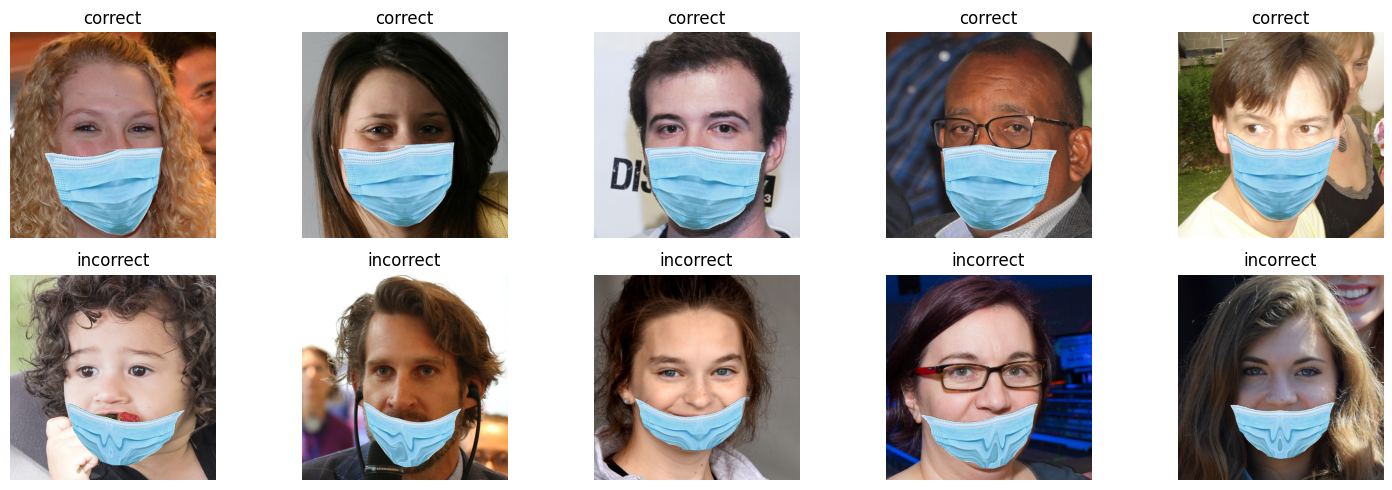

In [5]:
def show_samples(directory, samples=5):
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        images = os.listdir(class_path)[:samples]
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, samples, i*samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Training Samples:")
show_samples(train_dir)
print("\nTest Samples:")
show_samples(test_dir)

# Cell 5: Data Generators


In [6]:
# Calculate class weights and smoothing to prevent extreme weights
train_labels = []
for cls_idx, cls_name in enumerate(classes):
    cls_path = os.path.join(train_dir, cls_name)
    train_labels.extend([cls_idx] * len(os.listdir(cls_path)))

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {0: class_weights[0] * 0.9, 1: class_weights[1] * 1.1}  # Smoothing to reduce weight for class 0 by 10%, increases class 1 by 10%

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect',
    validation_split=0.2
)

# Validation generator
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 19307 images belonging to 2 classes.
Found 4826 images belonging to 2 classes.
Found 6034 images belonging to 2 classes.


# Cell 6: Model Architecture

At each block, i decided to use activation = "None" because when combining it with "LeakyReLU" is better when we use it with BatchNorm, it avoids dead neurons,  it is more flexible. When using BatchNorm, it's recommended to place it before the activation, so keeping activations separate allows better weight regularization.

**Algorithm Flowchart**

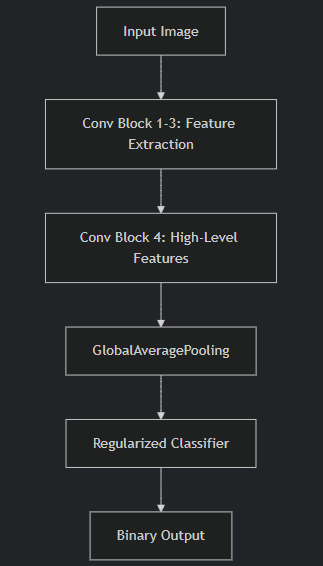

In [7]:
weight_decay = 0.005

# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy) #Enables mixed precision training which makes training faster and less memory usage

model = tf.keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    # Initial aggressive dropout to help prevent overfitting by randomly zeroing input pixels
    layers.Dropout(0.2, input_shape=(*IMG_SIZE, 3)),

    # Block 1
    layers.Conv2D(32, 5, padding='same', activation=None, kernel_regularizer=regularizers.l2(weight_decay)), # Decided to ues 5x5 fileter in block one to detect  edges, colors, and textures.
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),# used FLeakyRelu to fix the "dying ReLU" or so called "dead neurons" problem where neurons stop learning.
    layers.MaxPooling2D(2),
    layers.SpatialDropout2D(0.3),# SpatialDropout to prevents co-adaptation of features and forces network to learn redundant features

    # Block 2  Combines features into simple shapes
    layers.Conv2D(64, 3, padding='same', activation=None, kernel_regularizer=regularizers.l2(weight_decay)),# used "kernel_regularizer" to penalize big kernel weights for smoother predictions and to prevent overfitting.
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2),
    layers.SpatialDropout2D(0.4), # used only on the first three blocks becaause SpatialDropout2D drops entire feature maps but maintains spatial integrity within kept maps

    # Block 3  Recognizes complex patterns like mask edge or nose bridges
    layers.Conv2D(128, 3, padding='same', activation=None, kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.MaxPooling2D(2),
    layers.SpatialDropout2D(0.5),

    # Block 4  Identifies high-level features, for example: full mask or non-mask
    layers.Conv2D(256, 3, padding='same', activation=None, kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.GlobalAveragePooling2D(), # used GlobalAveragePolling2D at the 4th block because it produces high-level feature maps like "mask" vs "no mask" evidence
    layers.Dropout(0.6),

    # Classifier
    layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),
    layers.Dropout(0.7),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=0.5) #"clipnorm" to prevent exploding gradients

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 75, 75, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 37, 37, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 18, 18, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             

 Total params: 425,409 (1.62 MB)

 Trainable params: 424,193 (1.62 MB)

 Non-trainable params: 1,216 (4.75 KB)

# Cell 7: Training Configuration


In [7]:
def lr_schedule(epoch):  # this functions is very helpful to prevent overfitting, also to Improve convergence and avoid overshooting the optimal solution when the model is close to convergence.
    initial_lr = 0.0001
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.5
    elif epoch < 30:
        return initial_lr * 0.2
    else:
        return initial_lr * 0.1

callbacks = [
    ModelCheckpoint( # saves the best model by monitoring "val_auc"
        'best_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping( # if there is seen no improvement during training for at least 15 epochs, the model would stop running to prevent overfitting
        monitor='val_loss',
        patience=15,
        min_delta=0.0005,
        restore_best_weights=True # Reverts the model weights to the best epoch when stopped.
    ),
    LearningRateScheduler(lr_schedule),
    CSVLogger('training_log.csv', append=True),
    tf.keras.callbacks.TerminateOnNaN()
]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 336s 523ms/step - accuracy: 0.5056 - auc: 0.5104 - loss: 3.3066 - precision: 0.5142 - recall: 0.3802 - val_accuracy: 0.5044 - val_auc: 0.6203 - val_loss: 2.8067 - val_precision: 0.5035 - val_recall: 0.9996 - learning_rate: 1.0000e-04
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 294s 487ms/step - accuracy: 0.5138 - auc: 0.5165 - loss: 2.9439 - precision: 0.5121 - recall: 0.5434 - val_accuracy: 0.5027 - val_auc: 0.7552 - val_loss: 2.6139 - val_precision: 0.5027 - val_recall: 0.9996 - learning_rate: 1.0000e-04
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 295s 488ms/step - accuracy: 0.5395 - auc: 0.5547 - loss: 2.6258 - precision: 0.5411 - recall: 0.6042 - val_accuracy: 0.5027 - val_auc: 0.8646 - val_loss: 2.3952 - val_precision: 0.5027 - val_recall: 0.9930 - learning_rate: 1.0000e-04
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 302s 500ms/step - accuracy: 0.5698 - auc: 0.5999 - loss: 2.3176 - precision: 0.5637 - recall: 0.6514 - val_accuracy: 0.5116 - val_auc: 0.8

# Cell 8: Evaluation & Visualization


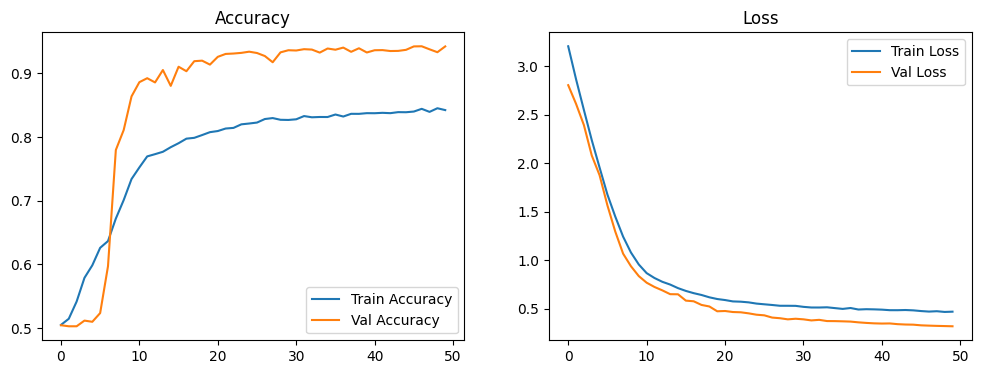

189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.9400 - auc: 0.4989 - loss: 0.3465 - precision: 0.4214 - recall: 0.4739
Test Accuracy: 93.64%
Test Precision: 97.75%
Test Recall: 94.26%


In [78]:
# Accuracy Graph
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss Graph
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Test evaluation
test_results = model.evaluate(test_generator)
print(f"Test Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_results[2]*100:.2f}%")
print(f"Test Recall: {test_results[3]*100:.2f}%")

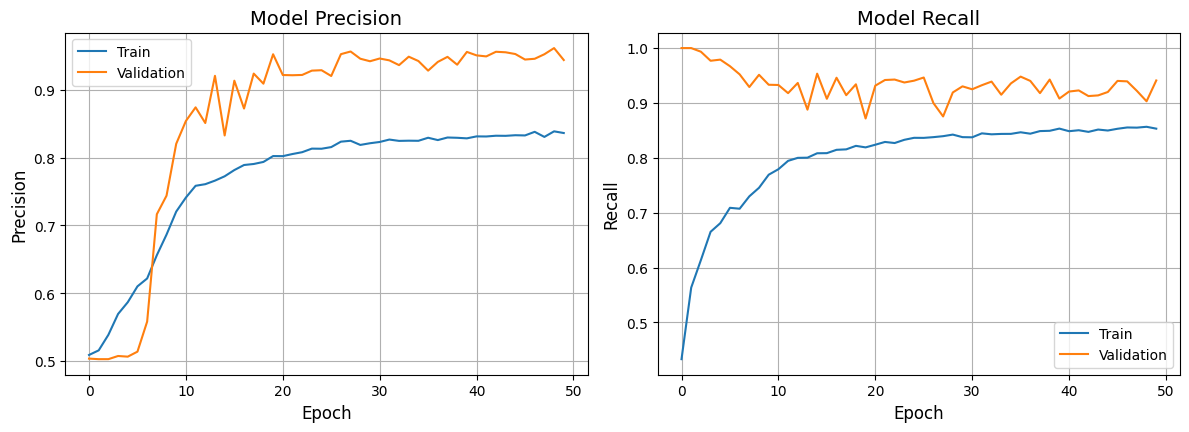

In [9]:
plt.figure(figsize=(12, 8))

# Precision graph
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train')
plt.plot(history.history['val_precision'], label='Validation')
plt.title('Model Precision', fontsize=14)
plt.ylabel('Precision', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.grid(True)

# Recall graph
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Validation')
plt.title('Model Recall', fontsize=14)
plt.ylabel('Recall', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

189/189 ━━━━━━━━━━━━━━━━━━━━ 46s 234ms/step


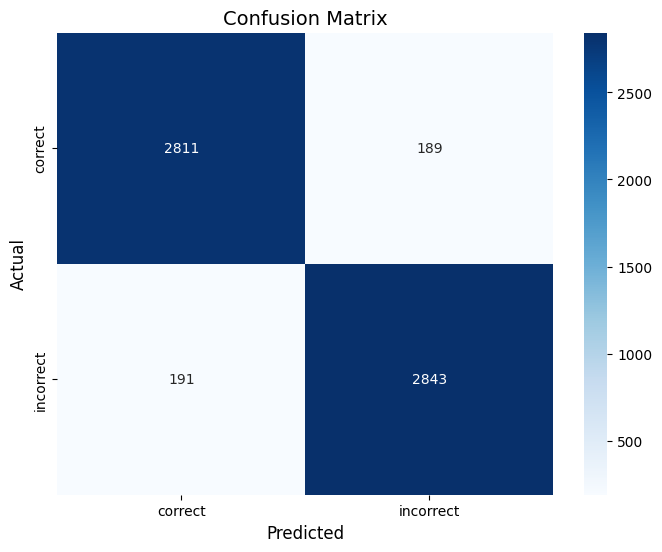


Classification Report:
              precision    recall  f1-score   support

     correct       0.94      0.94      0.94      3000
   incorrect       0.94      0.94      0.94      3034

    accuracy                           0.94      6034
   macro avg       0.94      0.94      0.94      6034
weighted avg       0.94      0.94      0.94      6034



In [10]:
# Confusion matrix and classification report

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Cell 9: Prediction Function
Select a random image and make a prediction if the person in the image is wearing the mask correctly or incorrectly

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


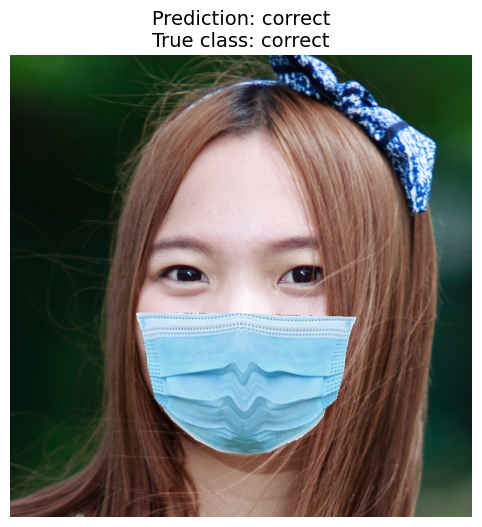

In [39]:
def predict_and_show(folder='random'):
    if folder == 'correct':
        class_folder = os.path.join(test_dir, 'correct')
    elif folder == 'incorrect':
        class_folder = os.path.join(test_dir, 'incorrect')
    else:
        class_folder = random.choice([
            os.path.join(test_dir, 'correct'),
            os.path.join(test_dir, 'incorrect')
        ])

    # Get random image from selected folder
    images = os.listdir(class_folder)
    random_image = random.choice(images)
    image_path = os.path.join(class_folder, random_image)

    img = cv2.imread(image_path)
    display_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Make the prediction
    pred = model.predict(img)[0][0]
    label = "correct" if pred > 0.5 else "incorrect"

    # Create the plot (without confidence)
    plt.figure(figsize=(8, 6))
    plt.imshow(display_img)
    plt.title(f"Prediction: {label}\nTrue class: {os.path.basename(class_folder)}", fontsize=14)
    plt.axis('off')
    plt.show()

    return label

result = predict_and_show()

# Cell 10: Save Model to Drive


In [76]:
# Save final model
model.save('/content/final_model.keras')

# Save the best model (loaded from checkpoint)
best_model = tf.keras.models.load_model('best_model.keras')
best_model.save('/content/best_model.keras')

drive_path = '/content/drive/MyDrive/MaskedFaceModels'
os.makedirs(drive_path, exist_ok=True)

# Copy all relevant files
shutil.copy('/content/final_model.keras', os.path.join(drive_path, 'final_model.keras'))
shutil.copy('/content/best_model.keras', os.path.join(drive_path, 'best_model.keras'))
shutil.copy('/content/training_log.csv', os.path.join(drive_path, 'training_log.csv'))

print("Models saved to Google Drive at:", drive_path)

Models saved to Google Drive at: /content/drive/MyDrive/MaskedFaceModels
